# Create timeseries of ECCOv4r4 sea surface height (SSH) change at a location

This notebook calculates SSH change from ECCOv4r4 data by reading the data directly from the PO.DAAC S3 data bucket on AWS us-west-2 region while working from a JupyterHub environment also located on us-west-2. 

Credit to Mike Croteau, who figured out the Earthdata authentication required to read directly from PO.DAAC S3 and very clearly documented the details in this notebook.

### Configuring Earthdata Authentication

You will need to setup Earthdata authentication to successfully use the PO.DAAC S3 bucket. A set of functions are included below to facilitate this (compiled from multiple sources, listed below). You can automate authentication by creating a ".netrc" file in your home directory and writing the following:

```
machine urs.earthdata.nasa.gov
    login <earthdata username>
    password <earthdata password>
```

On the JupyterHub, it is recommended that you do this from a terminal. First make sure you are in your home directory (`cd ~`), then create a new file and include the following:

```
cat >> .netrc
machine urs.earthdata.nasa.gov
    login <username>
    password <password>

```

Press `Enter` and then type `Ctrl+C` to save and close the prompt.

> **⚠️ Warning:** After writing the file, we _**strongly**_ recommend setting the new `.netrc` file to read-only for only the user using `chmod 0400 .netrc`. If you later need to edit this file, you can temporarily allow read/write by only the user with `chmod 0600 .netrc`. **NOTE:** Some users have found that they must reset the 0400 permissions every time they start a new server. If you find this to be the case, you can simply add the correct command to your bash profile or else run the first cell in this notebook. Alternatively, you may wish to forego using a .netrc file altogether and instead use the login prompt below to authenticate each time you use this notebook. _However, that prompt appears to be broken at this time..._

If configured successfully, you should see the following output from the second notebook cell.

```
# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.
```

Otherwise, you will see a message saying it could not use the .netrc file and it will ask you to input your username and password.

```
There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...
# Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.
Username: 
```

---

*Note: There is a pip package called "earthdata" that is supposed to help with this process, primarily in reducing code that we must write. However, we have not been able to get it to install on the JupyterHub.*

---

Sources:

- [Use Case: Study Amazon Estuaries with Data from the EOSDIS Cloud](https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Estuary_explore_inCloud_zarr.ipynb)
- [SWOT Oceanography with PO.DAAC](https://git.mysmce.com/eis-sealevel/swot/-/blob/main/tutorials/.ipynb_checkpoints/SWOT_simulated_L2_SSH_introduction-checkpoint.ipynb)
- ["Update cloud_direct_access_s3.py" - podaac tutorials commit 4da70c7cf079ddd7a6de4c4345749f580ba66d71](https://github.com/podaac/tutorials/commit/4da70c7cf079ddd7a6de4c4345749f580ba66d71#)

In [1]:
!chmod 0400 ~/.netrc

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from datetime import datetime
import progressbar

In [3]:
from urllib import request
from http.cookiejar import CookieJar
import netrc
import requests
import s3fs
import getpass

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.
    Valid endpoints:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
        print('# Your URS credentials were securely retrieved from your .netrc file.')
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print("There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...")
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass.getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
def begin_s3_direct_access():
    url="https://archive.podaac.earthdata.nasa.gov/s3credentials"
    r = requests.get(url)
    response = r.json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],secret=response['secretAccessKey'],token=response['sessionToken'],client_kwargs={'region_name':'us-west-2'})

edl = "urs.earthdata.nasa.gov"
setup_earthdata_login_auth(edl)
print('Earthdata login credentials configured. Ready.')

# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.


In [4]:
def find_pixels_at_locations(lat, lon, lat_locations, lon_locations, data=None):
    rows_cols = list()
    for lon_location, lat_location in zip(lon_locations, lat_locations):
        distance = np.sqrt( (lon - lon_location)**2 + (lat - lat_location)**2 )
        
        if data is not None:
            distance[np.isnan(data)] = np.nan

        rows_cols.append(np.unravel_index(np.nanargmin(distance), distance.shape))
    
    return rows_cols


## ECCO information and notes
Slides with info about the different ECCO versions:
https://events.ecmwf.int/event/199/contributions/1956/attachments/1109/2066/OceanDA21_Fenty.pdf

ECCOv4r4 data is here: https://podaac.jpl.nasa.gov/dataset/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4
* This is hosted in Earthdata cloud

ECCOv5 data is here: https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha
* This is not hosted in the cloud and must be downloaded


Helpful (potentially) resources and tutorials:
* https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial
* https://github.com/sea-level-change


In [5]:
# Initiate PO.DAAC S3 connection
fs = begin_s3_direct_access()

## Time series at a specific location

In [6]:
lat_gauges = list()
lon_gauges = list()

# Cox's Landing tide gauge location
lat_gauges.append(21.450000) # deg. north
lon_gauges.append(91.833333) # deg. east

n_tide_gauges = len(lat_gauges)


### ECCO

In [7]:
# Read first file for coordinate information
s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_MONTHLY_V4R4/*1992-01*nc'
s3_files = fs.glob(s3_bucket)
file = fs.open(s3_files[0])
ds = xr.open_dataset(file)
lat = ds.latitude[:]
lon = ds.longitude[:]
SSH = ds.SSH.values[0,:,:]
ds.close()

# Find the nearest valid data pixel to the location
lon_m, lat_m = np.meshgrid(lon, lat)
rcs = find_pixels_at_locations(lat_m, lon_m, lat_gauges, lon_gauges, data=SSH)


In [8]:
# Initialize arrays for SSH
ECCO_SSH_timeseries_monthly = np.zeros( (len(rcs), 312) )
ECCO_SSH_timeseries_yearly  = np.zeros( (len(rcs),  26) )

years = range(1992,2018)
months = range(1,13)
ECCO_dt = [datetime(y, m, 16) for y in years for m in months]
for iyear in progressbar.progressbar(range(len(years))):
    for imonth in range(len(months)):
        year = years[iyear]
        month = months[imonth]
        s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_MONTHLY_V4R4/*{:4d}-{:02d}*nc'.format(year,month)
        s3_files = fs.glob(s3_bucket)
        file = fs.open(s3_files[0])
        ds = xr.open_dataset(file)
        
        for irc, rc in enumerate(rcs):
            ECCO_SSH_timeseries_monthly[irc, iyear*12+imonth] = ds.SSH.values[0,rc[0],rc[1]]
            if imonth == 11:
                ECCO_SSH_timeseries_yearly[irc, iyear] = np.mean(ECCO_SSH_timeseries_monthly[irc, iyear*12:iyear*12+imonth])
                
        ds.close()


100% (26 of 26) |########################| Elapsed Time: 0:00:59 Time:  0:00:59


In [9]:
# Separate into sterodynamic and barystatic sea-level components

# Initialize arrays for ocean bottom pressure (OBP) - this is the barystatic component
ECCO_OBP_timeseries_monthly = np.zeros( (len(rcs), 312) )
ECCO_OBP_timeseries_yearly  = np.zeros( (len(rcs),  26) )

for iyear in progressbar.progressbar(range(len(years))):
    for imonth in range(len(months)):
        year = years[iyear]
        month = months[imonth]
        s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_OBP_05DEG_MONTHLY_V4R4/*{:4d}-{:02d}*nc'.format(year,month)
        s3_files = fs.glob(s3_bucket)
        file = fs.open(s3_files[0])
        ds = xr.open_dataset(file)
        
        for irc, rc in enumerate(rcs):
            ECCO_OBP_timeseries_monthly[irc, iyear*12+imonth] = ds.OBP.values[0,rc[0],rc[1]]
            if imonth == 11:
                ECCO_OBP_timeseries_yearly[irc, iyear] = np.mean(ECCO_OBP_timeseries_monthly[irc, iyear*12:iyear*12+imonth])
                
        ds.close()
        
# Steric component is total minus OBP (barystatic)
ECCO_steric_timeseries_monthly = ECCO_SSH_timeseries_monthly - ECCO_OBP_timeseries_monthly
ECCO_steric_timeseries_yearly = ECCO_SSH_timeseries_yearly - ECCO_OBP_timeseries_yearly


100% (26 of 26) |########################| Elapsed Time: 0:00:55 Time:  0:00:55


total trend      =    3.6 mm/yr
barystatic trend =    4.0 mm/yr
steric trend     =   -0.4 mm/yr


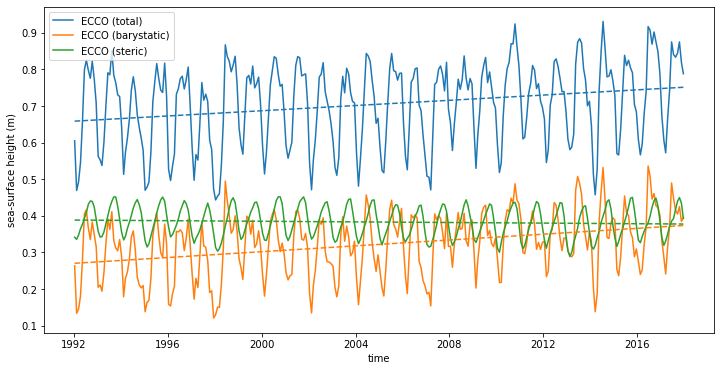

In [10]:
fig = plt.figure(figsize=(12,6))

ECCO_SSH_timeseries_trend = np.zeros(ECCO_SSH_timeseries_monthly.shape)
ECCO_OBP_timeseries_trend = np.zeros(ECCO_OBP_timeseries_monthly.shape)
ECCO_steric_timeseries_trend = np.zeros(ECCO_steric_timeseries_monthly.shape)

# Extract data for plotting
for k in range(n_tide_gauges):
    p_total = plt.plot(ECCO_dt,        ECCO_SSH_timeseries_monthly[k,:], '-', label='ECCO (total)')
    p_barys = plt.plot(ECCO_dt,        ECCO_OBP_timeseries_monthly[k,:], '-', label='ECCO (barystatic)')
    p_steri = plt.plot(ECCO_dt,        ECCO_steric_timeseries_monthly[k,:], '-', label='ECCO (steric)')

    p = np.polyfit(range(312), ECCO_SSH_timeseries_monthly[k,:], 1)
    ECCO_SSH_timeseries_trend[k,:] = np.polyval(p, range(312))
    plt.plot(ECCO_dt, ECCO_SSH_timeseries_trend[k,:], '--', c=p_total[0].get_color())
    print('total trend      = {: 6.1f} mm/yr'.format(p[0] * 1000 * 12))
    
    p = np.polyfit(range(312), ECCO_OBP_timeseries_monthly[k,:], 1)
    ECCO_OBP_timeseries_trend[k,:] = np.polyval(p, range(312))
    plt.plot(ECCO_dt, ECCO_OBP_timeseries_trend[k,:], '--', c=p_barys[0].get_color())
    print('barystatic trend = {: 6.1f} mm/yr'.format(p[0] * 1000 * 12))
    
    p = np.polyfit(range(312), ECCO_steric_timeseries_monthly[k,:], 1)
    ECCO_steric_timeseries_trend[k,:] = np.polyval(p, range(312))
    plt.plot(ECCO_dt, ECCO_steric_timeseries_trend[k,:], '--', c=p_steri[0].get_color())
    print('steric trend     = {: 6.1f} mm/yr'.format(p[0] * 1000 * 12))

plt.legend()
plt.xlabel('time')
_ = plt.ylabel('sea-surface height (m)')


### Write a csv file timeseries

In [11]:
# Select the tide gauge location
i_tide_gauge = 0

In [12]:
from dateutil.relativedelta import relativedelta
# stores 31 days that can be added
addMonths = relativedelta(months=1)

f = open('ecco_ssh.csv','w')

f.write('date,source,SSH (m)\n')
for i, dt in enumerate(ECCO_dt):
    f.write('{:s},Total,{:f}\n'.format(datetime.strftime(dt, '%m/%Y'), ECCO_SSH_timeseries_monthly[i_tide_gauge,i]))
    f.write('{:s},Barystatic,{:f}\n'.format(datetime.strftime(dt, '%m/%Y'), ECCO_OBP_timeseries_monthly[i_tide_gauge,i]))
    f.write('{:s},Steric,{:f}\n'.format(datetime.strftime(dt, '%m/%Y'), ECCO_steric_timeseries_monthly[i_tide_gauge,i]))
    
    #f.write('{:s},total (trend),{:f}\n'.format(datetime.strftime(dt, '%m/%Y'), ECCO_SSH_timeseries_trend[i_tide_gauge,i]))
    #f.write('{:s},barystatic (trend),{:f}\n'.format(datetime.strftime(dt, '%m/%Y'), ECCO_OBP_timeseries_trend[i_tide_gauge,i]))
    #f.write('{:s},steric (trend),{:f}\n'.format(datetime.strftime(dt, '%m/%Y'), ECCO_steric_timeseries_trend[i_tide_gauge,i]))

f.close()


In [13]:
# Copy the csv to the delta-config repository
!head ecco_ssh.csv
!cp ecco_ssh.csv ../../delta-config/discoveries

date,source,SSH (m)
01/1992,Total,0.605101
01/1992,Barystatic,0.263615
01/1992,Steric,0.341486
02/1992,Total,0.469296
02/1992,Barystatic,0.133590
02/1992,Steric,0.335706
03/1992,Total,0.491685
03/1992,Barystatic,0.144626
03/1992,Steric,0.347059
